In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from itertools import chain
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import transform_fns as trans
import pdm_functions as fns
import tensor_vstack as pfns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import gaussian_kde
from sklearn.utils.class_weight import compute_class_weight

import pickle
from tqdm.notebook import tqdm


In [2]:
# data_stacked = torch.load('data/train_data_stacked.pt', weights_only=True)
# X_train = data_stacked['X_train_stacked'][35000:40000]
# y_train = data_stacked['y_train_stacked'][35000:40000]

In [3]:
# data_stacked = torch.load('data/train_set_for_model_structure.pt', weights_only=True)
# data_stacked_test = torch.load('data/test_data_stacked.pt', weights_only=True)
# data_stacked_dev = torch.load('data/dev_data_stacked.pt', weights_only=True)

# X_train = data_stacked['X_train_for_model_structure']
# y_train = data_stacked['y_train_for_model_structure']

In [4]:
# X_test = data_stacked_test['X_test_stacked']
# y_test = data_stacked_test['y_test_stacked']
# X_test.shape, y_test.shape

# X_dev = data_stacked_dev['X_dev_stacked']
# y_dev = data_stacked_dev['y_dev_stacked']
# X_dev.shape, y_dev.shape

In [2]:
data_stacked = torch.load('data/spec_datasets.pt', weights_only=True)
# # data_stacked['X_train']
# # data_stacked['y_train']
# # data_stacked['X_dev']
# # data_stacked['y_dev']
# # data_stacked['X_test']
# # data_stacked['y_test']
X_train = data_stacked['X_train']
y_train = data_stacked['y_train']
X_train.shape, y_train.shape

(torch.Size([2600, 1, 36, 2048]), torch.Size([2600]))

In [3]:
len(y_train[y_train == 0]), len(y_train[y_train != 0])

(1170, 1430)

In [4]:
X_test = data_stacked['X_test']
y_test = data_stacked['y_test']
X_test.shape, y_test.shape

X_dev = data_stacked['X_dev']
y_dev = data_stacked['y_dev']
X_dev.shape, y_dev.shape

(torch.Size([370, 1, 36, 2048]), torch.Size([370]))

## 가중치 함수

In [8]:
file_path='data/weight/5520_spectrum_x_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_x = torch.tensor(data)

file_path='data/weight/5520_spectrum_y_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_y = torch.tensor(data)

file_path='data/weight/5520_spectrum_z_weights.pkl'
with open(file_path, 'rb') as f: 
    data = pickle.load(f)
wf_z = torch.tensor(data)

wf_xyz = torch.stack((wf_x, wf_y, wf_z))
print(wf_x.shape, wf_y.shape, wf_z.shape, wf_xyz.shape)

torch.Size([2048]) torch.Size([2048]) torch.Size([2048]) torch.Size([3, 2048])


## 가중치 함수 브로드 캐스팅

In [56]:
wf_broadcast = 100000

In [57]:
X_train_stacked = X_train * wf_xyz.repeat(12, 1) * wf_broadcast
X_dev_stacked = X_dev * wf_xyz.repeat(12, 1) * wf_broadcast
X_test_stacked = X_test * wf_xyz.repeat(12, 1) * wf_broadcast
# X_dev_stacked2 = X_dev_stacked2 * wf_xyz.repeat(12, 1)

<Axes: >

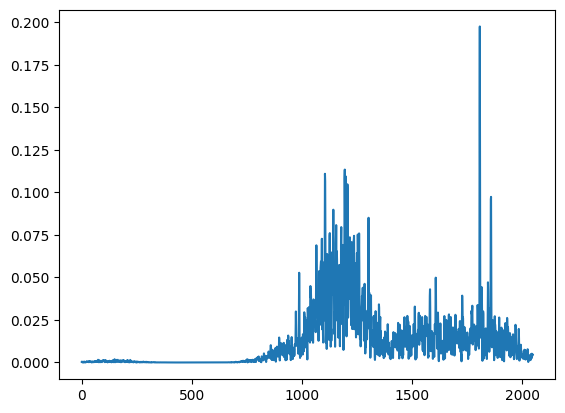

In [58]:
sns.lineplot(X_train_stacked[0][0][0])

## 데이터셋, 데이터로더 설정

In [11]:
# X_train_stacked = X_train 
# X_dev_stacked = X_dev
# X_test_stacked = X_test 

In [12]:
train_dataset = TensorDataset(X_train_stacked, y_train)

In [13]:
test_dataset = TensorDataset(X_test_stacked, y_test)

In [14]:
dev_dataset = TensorDataset(X_dev_stacked, y_dev)

In [15]:
batch_size = 128
dataloader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size , shuffle=True)

In [16]:
for x_batch, labels in dataloader_dev:
    print(x_batch.shape)
    break
for x_batch, labels in dataloader_test:
    print(x_batch.shape)
    break
for x_batch, labels in dataloader:
    print(x_batch.shape)
    break

torch.Size([128, 1, 36, 2048])
torch.Size([37, 1, 36, 2048])
torch.Size([128, 1, 36, 2048])


### BCEWithLogitsLoss pos_weight 계산

In [17]:
# 레이블 준비 (0: negative, 1: positive라고 가정)
y = np.array(dataloader_test.dataset[:][1]) 

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# BCEWithLogitsLoss에 사용할 pos_weight 계산
pos_weight = torch.tensor(class_weights[1])

In [18]:
class_weights

array([6.16666667, 0.54411765])

In [39]:
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1)),  # First Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Conv2d(8, 32, kernel_size=(3, 1), stride=(3, 1)),  # Second Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Conv2d(32, 8, kernel_size=(12, 2), stride=(12, 2)),  # Third Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    nn.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1)),  # Fourth Conv Layer
    nn.Dropout(p=0.3),
    nn.ReLU(),
    
    
    nn.Flatten(),
    
    nn.Linear(1024, 256), 
    nn.ReLU(),
    
    nn.Linear(256, 128),
    nn.ReLU(),
    
    nn.Linear(128, 64), 
    nn.ReLU(),
    
    nn.Linear(64, 16),
    nn.ReLU(),
    
    nn.Linear(16, 1)
        )

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device)) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Conv모델 학습

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5049
Epoch [2/10], Loss: 0.5040
Epoch [3/10], Loss: 0.5035
Epoch [4/10], Loss: 0.5008
Epoch [5/10], Loss: 0.4812
Epoch [6/10], Loss: 0.3549
Epoch [7/10], Loss: 0.1586
Epoch [8/10], Loss: 0.0956
Epoch [9/10], Loss: 0.0656
Epoch [10/10], Loss: 0.0316


<Axes: >

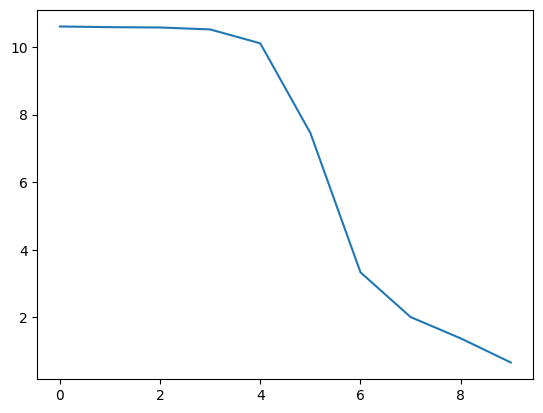

In [32]:
print(device)

model = model.to(device)
loss_plot = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for x_batch, labels in dataloader:
        optimizer.zero_grad()

        x_batch = x_batch.to(device)  # Move x_batch to device
        labels = labels.to(device).float()
        labels = labels.unsqueeze(1)
        
        outputs = model(x_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    loss_plot.append(running_loss)
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

sns.lineplot(loss_plot)

In [81]:
# dataloader_dev.dataset[0:37][1]

In [82]:
# model = torch.load('1003)stacked_model(0.68).pth')

## 모델 평가

In [36]:
threshold = 0.5
dataset = dataloader_test

In [37]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = torch.load('1005)stacked_model(dev-0.9705).pth', map_location=torch.device(device))
# model.eval()
# with torch.no_grad():
#     for x_batch, labels in dataset:
#         x_batch = x_batch.to(device)
#         outputs = model(x_batch)
#         front_predict = (torch.sigmoid(outputs) > threshold).int()
#     print(labels.tolist())
#     print(front_predict.view(-1,).tolist())

In [38]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

# Initialize variables to keep track of the loss and prediction
total_loss = 0.0
all_labels = []
all_predictions = []
correct_cnt = 0
neg_pred_cnt = 0

with torch.no_grad():
    for x_batch, labels in dataset:
        x_batch = x_batch.to(device)
        labels = labels.to(device).long()
        outputs = model(x_batch)  # Forward pass
        
        loss = criterion(outputs, labels.view(-1,1).float())  # Calculate loss
        total_loss += loss.item()  # Accumulate the loss
        
        # Get predictions
        predicted = (torch.sigmoid(outputs) > threshold).int()
        
        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_predictions.extend(predicted.cpu().numpy().flatten())  # Store predicted labels

# Calculate average loss
avg_loss = total_loss / len(dataset)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
cm = confusion_matrix(all_labels, all_predictions)

TN = cm[0, 0]  
FP = cm[0, 1] 
FN = cm[1, 0]  
TP = cm[1, 1]  

# FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  
# FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  

Neg_precision = TN/(FN+TN) if (FN + TN) > 0 else 0   
Neg_recall =TN/(FP+TN) if (TN + FP) > 0 else 0  
 

# Print results

print(f"Evaluation Loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
# print(f'Predicted positives out of all negatives: {FPR} = {FP}/{FP + TN}')
# print(f'Predicted negatives out of all positives: {FNR} = {FN}/{FN + TP}')
print(all_labels)
print(all_predictions)
for i in range(len(all_labels)) :
    if all_labels[i] == 0 and all_predictions[i] == 0:
        correct_cnt += 1
for pred in all_predictions:
    if pred == 0:
        neg_pred_cnt += 1

print(f'correct_cnt {correct_cnt}')
print(f'neg_pred_cnt {neg_pred_cnt}')
print(f'Neg_Precision: {Neg_precision:.4f} = {TN}/{FN + TN}, Neg_Recall: {Neg_recall:.4f} = {TN}/{FP + TN}, Neg_F1:  {2* (Neg_precision * Neg_recall)/(Neg_precision + Neg_recall):.4f}') 
print(f"\nParameter - Weight : {wf_broadcast}, epoch : {num_epochs}, lr : {learning_rate}, threshold : {threshold}")

# len(all_labels) 

cuda
Evaluation Loss: 0.0733
Precision: 0.9595, Recall: 0.9189, F1 Score: 0.9306
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]
correct_cnt 3
neg_pred_cnt 6
Neg_Precision: 0.5000 = 3/6, Neg_Recall: 1.0000 = 3/3, Neg_F1:  0.6667


NameError: name 'wf_broadcast' is not defined

In [150]:
# dataload = dataloader_dev

# model.eval()
# # Initialize variables to keep track of the loss and predictions
# total_loss = 0.0
# all_labels = []
# all_predictions = []
# correct_cnt = 0
# miss_cnt = 0
# label_zero = 0

# with torch.no_grad():
#     for x_batch, labels in dataload:  # Assuming you have a separate validation or test DataLoader
#         x_batch = x_batch.to(device)  # Move x_batch to device
#         labels = labels.to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

#         outputs = model(x_batch)  # Forward pass
#         outputs = outputs.reshape(-1)
#         loss = criterion(outputs, labels)  # Calculate loss
#         total_loss += loss.item()  # Accumulate the loss

#         # Apply sigmoid to the outputs to get probabilities
#         print (outputs)
#         print(torch.sigmoid(outputs))
        
#         predicted = (torch.sigmoid(outputs) > 0.9).float()  # Convert probabilities to binary predictions
        
#         all_labels.extend(labels.cpu().numpy())  # Store true labels
#         all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

# # Calculate average loss
# avg_loss = total_loss / len(dataload)  # Use the correct dataloader for length

# # Calculate precision, recall, and F1 score
# precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'micro' or 'macro' if needed
# recall = recall_score(all_labels, all_predictions, average='weighted')
# f1 = f1_score(all_labels, all_predictions, average='weighted')

# # Print results
# print(f"Evaluation Loss: {avg_loss:.4f}")
# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
# all_labels = [label for label in all_labels]  # Extract first element from each array
# all_predictions = [pred for pred in all_predictions]  # Extract first element from each array

# for i in range(len(all_labels)):
#     if all_labels[i] == 0:  # all_labels의 값이 0인지 확인
#         label_zero += 1
#         if all_predictions[i] == 0:  # all_predictions의 값이 0인지 확인
#             correct_cnt += 1  # cnt를 증가시킴
#         else: miss_cnt += 1
# pred_zero_cnt = 0
# for i in range(len(all_predictions)):
#     if all_predictions[i] == 0:
#         pred_zero_cnt += 1

# print(all_labels)
# print(all_predictions)
# print(f"correct : {correct_cnt}/{label_zero}")
# print(f"predicted zero : {pred_zero_cnt}")

# cm = confusion_matrix(all_labels, all_predictions)
 
# TN = cm[0, 0]  
# FP = cm[0, 1] 
# FN = cm[1, 0]  
# TP = cm[1, 1]  
 
# FPR = TN / (FN + TN) if (FN + TN) > 0 else 0  
# FNR = TN / (TN + FP) if (TN + FP) > 0 else 0  
 
# print(f'Neg_Precision: {FPR} ') 
# print(f'Neg_Recall: {FNR}')

### Autoencoder 학습

In [28]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class Autoencoder(nn.Module):
#     def __init__(self, latent_dim):
#         super(Autoencoder, self).__init__()
#         self.latent_dim = latent_dim
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((9, 256)),  # 크기를 고정
#             nn.Flatten(),
#             nn.Linear(64 * 9 * 256, latent_dim)
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 64 * 9 * 256),
#             nn.Unflatten(1, (64, 9, 256)),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Upsample(size=(36, 2048), mode='bilinear', align_corners=False),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [29]:
# learning_rate = 0.001
# num_epochs = 10

# last_dim = 512
# model = Autoencoder(last_dim)
# criterion = nn.MSELoss()  # 손실 함수
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam 옵티마이저

In [30]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = model.to(device)
# for epoch in tqdm(range(num_epochs)):
#     model.train()  # 학습 모드
#     running_loss = 0.0
#     for x_batch,labels in dataloader:
#         x_batch = x_batch.to(device)
        
#         optimizer.zero_grad()  # 기울기 초기화
        
#         outputs = model(x_batch)  # Autoencoder 출력
        
        
#         loss = criterion(outputs, x_batch)  # 손실 계산
        
#         loss.backward()  # 기울기 계산
#         optimizer.step()  # 파라미터 업데이트
        
#         running_loss += loss.item()
    
#     epoch_loss = running_loss / len(dataloader_dev)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [31]:
# from sklearn.metrics import classification_report

# model.eval()
# all_labels = []
# all_predictions = []
# all_errors = []

# # MSE 손실 함수 인스턴스 생성
# criterion = nn.MSELoss(reduction='none')

# with torch.no_grad():
#     for data, labels in tqdm(dataloader_dev):
#         data = data.to(device)
#         labels = labels.to(device)  # 레이블도 GPU로 이동
        
#         # Forward pass: input to autoencoder
#         reconstructed = model(data)
        
#         # Compute reconstruction error (MSE)
#         reconstruction_error = criterion(reconstructed, data)  # 손실 계산
#         reconstruction_error = reconstruction_error.mean(dim=[1, 2, 3])  # Averaging over all dimensions
#                 # Store the actual labels and reconstruction errors
#         all_labels.append(labels)
#         all_errors.append(reconstruction_error)

# # concatenate results and move to CPU
# all_labels = torch.cat(all_labels).cpu().numpy()
# all_errors = torch.cat(all_errors).cpu().numpy()

In [32]:
# # Binary classification: if error > threshold -> anomaly (1), else normal (0)
# threshold = 0.3  # 적절한 threshold 값을 설정해야 합니다
# all_predictions = (all_errors > threshold).astype(int)

# # Evaluation metrics
# print(classification_report(all_labels, all_predictions))

In [33]:
# torch.save(model, '1005)stacked_model(dev-0.9705).pth')

In [34]:
# torch.load('1003)stacked_model(0.68).pth')